In [1]:
!pip install ibmos2spark
!pip install tensorflow==2.0.0b1

print("NEED TO RESTART KERNAL")
print("NEED TO RESTART KERNAL")
print("NEED TO RESTART KERNAL")

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190829131438-0000
KERNEL_ID = 8dcfffd4-e6e8-4e7a-9100-be18344fc600


In [ ]:
import tensorflow as tf
print(tf.__version__)
print("SHOULD SEE: 2.0.0-beta1")

In [200]:
# Configuration

# 'countries' list used to iterate
 

countries = ['Australia', 'Brazil', 'Canada', 
         'Denmark', 'EU', 'India', 'Japan',
         'New_Zealand', 'Norway',
         'Singapore', 'South_Africa', 'South_Korea',
         'Sri_Lanka', 'Sweden', 'Switzerland', 'Taiwan',
         'Thailand', 'United_Kingdom']

# Removing the following countries from training due to currency collapse
# during the interval.
# 
# ['Venezuela']
#
# Removing the following because low variance demonstrates a fixed-currency
# over the interval
#
# ['Hong_Kong', 'China', 'Malaysia']

this_stage = "feature_eng"
previous_stage = "etl"

In [4]:
import ibmos2spark
from pyspark.sql.types import *

# Configuration
# Prepare to access IBM Object Storage

# @hidden_cell
credentials = {
    'service_id': 'iam-ServiceId-e4b1b62b-e030-4b68-a71f-a12e44f23c33',
    'api_key': '9-RaWWhWwA-jm5BkfQ1pxtj-J5xvpjYKMrSgMk9vQxX1',
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'bucket': 'forex-donotdelete-pr-ksiby6mz5os7oj'
}

# configuration_name = 'os_forex'
configuration_name = ''
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

print(type(cos))

bucket_name = 'forex-donotdelete-pr-ksiby6mz5os7oj'

<class 'ibmos2spark.osconfig.CloudObjectStorage'>


In [5]:
data_url = cos.url(previous_stage + ".parquet", bucket_name)
df = spark.read.format("parquet").load(data_url)
df = df.sort('Date', ascending=True)
df.show()

+----------+---------+------+------+------+-------+------+---------+-----+------+--------+-----------+------+---------+------------+-----------+---------+------+-----------+------+--------+--------------+---------+
|      Date|Australia|Brazil|Canada| China|Denmark|    EU|Hong_Kong|India| Japan|Malaysia|New_Zealand|Norway|Singapore|South_Africa|South_Korea|Sri_Lanka|Sweden|Switzerland|Taiwan|Thailand|United_Kingdom|Venezuela|
+----------+---------+------+------+------+-------+------+---------+-----+------+--------+-----------+------+---------+------------+-----------+---------+------+-----------+------+--------+--------------+---------+
|2000-01-04|   0.6562|1.8405|1.4518|8.2799|  7.218|1.0309|   7.7775|43.55|103.09|     3.8|     0.5198| 7.934|   1.6535|       6.085|     1122.5|    72.65|  8.36|     1.5565|  30.6|   37.13|         1.637|   0.6503|
|2000-01-05|    0.655| 1.856|1.4518|8.2798|  7.208|1.0335|    7.778|43.55|103.77|     3.8|     0.5171| 7.935|    1.656|        6.07|     113

In [77]:
"""
Guidelines for feature transformation:

· Imputing Some algorithms are very sensitive to missing values. Therefore, imputing allows for filling of empty fields based on its value distribution

· Imputed time-series quantization Time series often contain streams with measurements at different timestamps. Therefore, it is beneficial to quantize measurements to a common “heart beat” and impute the corresponding values. This can be done by sampling from the source time series distributions on the respective quantized time steps

· Scaling / Normalizing / Centering Some algorithms are very sensitive differences in value ranges for individual fields. Therefore, it is best practice to center data around zero and scale values to a standard deviation of one

· Filtering Sometimes imputing values doesn’t perform well, therefore deletion of low quality records is a better strategy

· Discretizing Continuous fields might confuse the model, e.g. a discrete set of age ranges sometimes performs better than continuous values, especially on smaller amounts of data and with simpler models

The following none exhaustive list gives you some guidelines for feature creation:

· One-hot-encoding Categorical integer features should be transformed into “one-hot” vectors. In relational terms this results in addition of additional columns – one columns for each distinct category

· Time-to-Frequency transformation Time-series (and sometimes also sequence data) is recorded in the time domain but can easily transformed into the frequency domain e.g. using FFT (Fast Fourier Transformation)

· Month-From-Date Creating an additional feature containing the month independent from data captures seasonal aspects. Sometimes further discretization in to quarters helps as well

· Aggregate-on-Target Simply aggregating fields the target variable (or even other fields) can improve performance, e.g. count number of data points per ZIP code or take the median of all values by geographical region

"""

'\nGuidelines for feature transformation:\n\n· Imputing Some algorithms are very sensitive to missing values. Therefore, imputing allows for filling of empty fields based on its value distribution\n\n· Imputed time-series quantization Time series often contain streams with measurements at different timestamps. Therefore, it is beneficial to quantize measurements to a common “heart beat” and impute the corresponding values. This can be done by sampling from the source time series distributions on the respective quantized time steps\n\n· Scaling / Normalizing / Centering Some algorithms are very sensitive differences in value ranges for individual fields. Therefore, it is best practice to center data around zero and scale values to a standard deviation of one\n\n· Filtering Sometimes imputing values doesn’t perform well, therefore deletion of low quality records is a better strategy\n\n· Discretizing Continuous fields might confuse the model, e.g. a discrete set of age ranges sometimes p

In [ ]:
import numpy as np

############################
# Basic model hyperparams  #
############################

# Since a week is represented by the 5 days (Mon-Fri) when an exhange
# rate trade can be made, one month is roughly 20 time steps.
window_size = 20
batch_size = 160
shuffle_buffer_size = 1000

# returns a series truncated so as to fit evenly into batch_size
def createEvenlyDivisible(series, batch_size):
    magic_len = series.shape[0] - (series.shape[0] % batch_size)
    return series[:magic_len]

all_series = {}
all_train = {}
all_valid = {}
split_time = 0
time_len = 0
count = 0

# MIKE: 1) need to calculate the ROLLING VARIANCE over window_size
#          for each of the currencies to check for pegged rates.
#       2) it may also be useful to look for seasonality by running 
#          each series through a Fourier Transform
#       3) some analysis of correlations between the series may be 
#          appropriate
#       4) day_of_week & month might be features worth adding


for country in countries:
    series = np.array(df.select(country).collect()) 
    series = series.reshape(series.shape[0])
    all_series[country] = series
    max_rate = np.max(series)
    min_rate = np.min(series)
    all_series[country+"_max_rate"] = max_rate 
    all_series[country+"_min_rate"] = min_rate 

    ###########################################
    # Splitting data for train/validation at  #
    # the middle of the time interval         #
    ###########################################
    # x_train = createEvenlyDivisible(x_train, batch_size)
    print("Centering the data by subtracing the minimum: " + str(min_rate))
    series = series - min_rate
    print("Normalizing the data dividing by (max - min): " + str(max_rate) + " - " + str(min_rate))
    series = series / (max_rate - min_rate) 
    
    x_train_len = len(series) // 2
    x_train = series[0:x_train_len]
    all_train[country] = x_train
    all_train[country+"_len"] = x_train_len
    all_train[country+"_min"] = min_rate
    all_train[country+"_max"] = max_rate
    
    print(country + " has " + str(x_train_len) + " training rows.")

    split_time = split_time + x_train_len

    # x_valid = createEvenlyDivisible(x_valid, batch_size)
    x_valid = series[x_train_len:-1]
    all_valid[country] = x_valid
    x_valid_len = x_valid.shape[0]    
    all_valid[country+"_len"] = x_valid_len
    print(country + " has " + str(x_train_len) + " training rows.")

    time_len = time_len + x_train_len + x_valid_len
    
    if count==0:
        x_train_all = x_train
        x_valid_all = x_valid
    else:
        x_train_all = np.append(x_train_all, x_train)
        x_valid_all = np.append(x_valid_all, x_valid)
    count+=1

series_all = np.append(x_train_all, x_valid_all)

###########################################
# Splitting time indices for visualizing  #
###########################################

time = np.array(range(time_len))
time_train = time[:split_time]
time_valid = time[split_time:]

print(series_all.shape)
print(x_train_all.shape)
print(x_valid_all.shape)

Centering the data by subtracing the minimum: 0.4828000068664551
Normalizing the data dividing by (max - min): 1.1025999784469604 - 0.4828000068664551
Australia has 2455 training rows.
Australia has 2455 training rows.
Centering the data by subtracing the minimum: 1.537500023841858
Normalizing the data dividing by (max - min): 4.201600074768066 - 1.537500023841858
Brazil has 2455 training rows.
Brazil has 2455 training rows.
Centering the data by subtracing the minimum: 0.9168000221252441
Normalizing the data dividing by (max - min): 1.6128000020980835 - 0.9168000221252441
Canada has 2455 training rows.
Canada has 2455 training rows.
Centering the data by subtracing the minimum: 4.6605000495910645
Normalizing the data dividing by (max - min): 9.005000114440918 - 4.6605000495910645
Denmark has 2455 training rows.
Denmark has 2455 training rows.
Centering the data by subtracing the minimum: 0.8270000219345093
Normalizing the data dividing by (max - min): 1.6009999513626099 - 0.8270000219

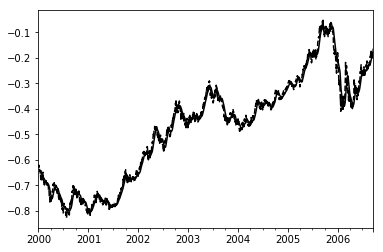

In [199]:
# For viewing various series and validating previous process #

import pandas as pd
import numpy as np
%matplotlib inline

#china_series = all_series["Malaysia"][0:300]
#china_series = all_series["Hong_Kong"]
china_series = all_train["EU"]
#china_series = all_valid["China"]


# some sample data
ts = pd.Series(china_series, index=pd.date_range('1/1/2000', periods=len(china_series)))
#ts = pd.Series(china_series, index=pd.date_range('1/1/2000', periods=300))

#plot the time series
ts.plot(style='k--')

# calculate a 60 day rolling mean and plot
ts.rolling(window=window_size).mean().plot(style='k')


In [123]:
print("Total data instances in training set: " + str(len(x_train_all)))

54010

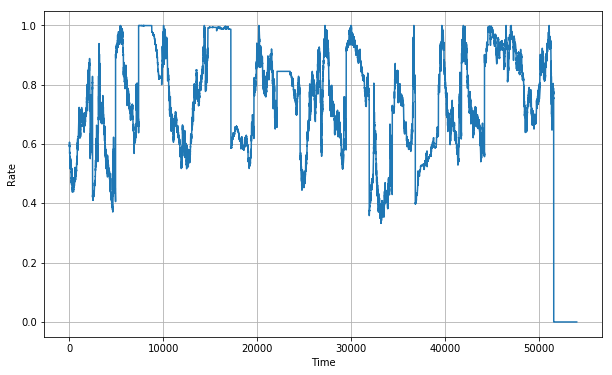

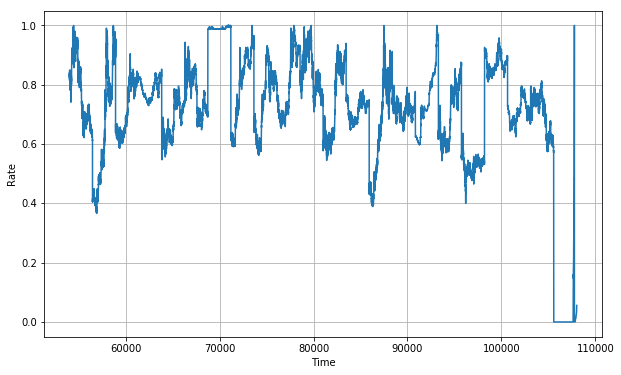

In [122]:
# The intention is to train a general purpose model initially,
# which can be used later using transfer learning to create 
# pairwise exchange rate predictors (e.g. for rates between two
# specific countries)
#
# Therefor, the data needs to be organized as 18 separate sequences.
# It would be beneficial to use a different 'split_time' to 
# separate each country's train / test split so as to train
# using a sample over the complete time interval, but we will 
# start by just splitting at the time midpoint.

import matplotlib.pyplot as plt
%matplotlib inline

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Rate")
    plt.grid(True)
    
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train_all)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid_all)
plt.show()

[80000, 80100, 0.65, 1.0]

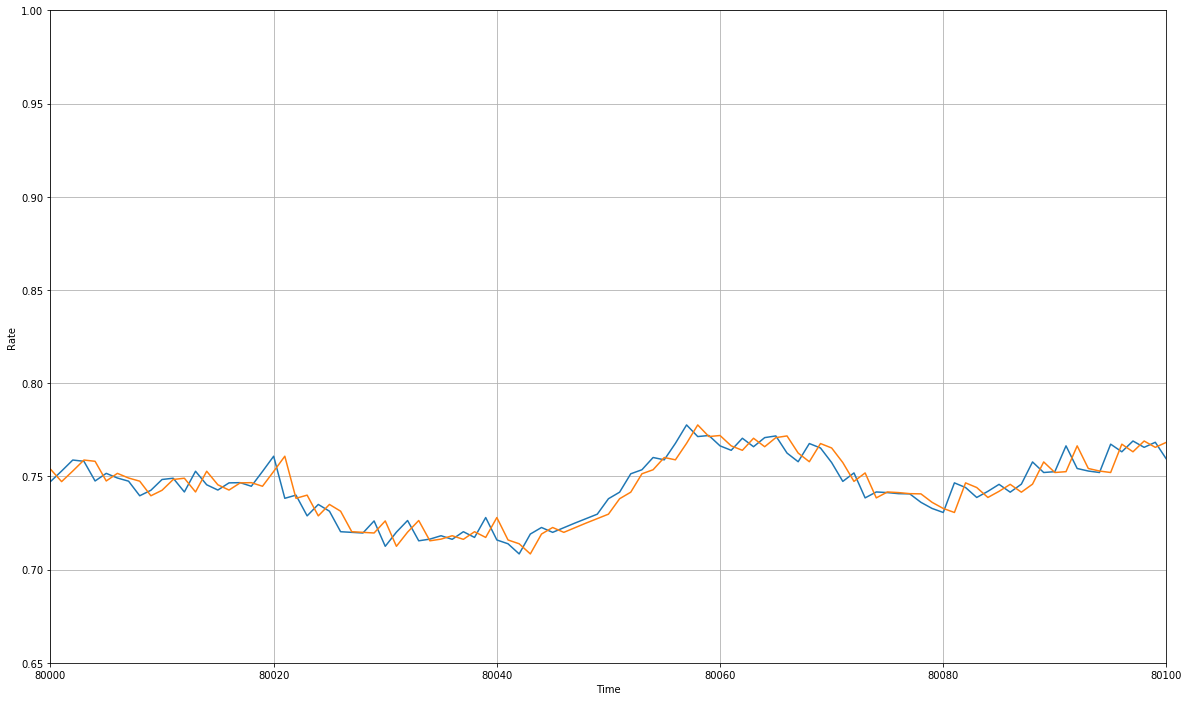

In [140]:
############################################################
# Establishing a forecasting baseline using the
# most naive model, assuming the Rate at the next 
# time step will be exactly what it is at the current one.
# The implied trading strategy for this model would always 
# be ambivalence; therefor, if we cannot improve on this, 
# we cannot trade with our model.
############################################################

naive_forecast = series_all[split_time-1:-1]
plt.figure(figsize=(20, 12))
plot_series(time_valid, x_valid_all)
plot_series(time_valid, naive_forecast)
plt.axis([80000, 80100, 0.65, 1.0])

In [143]:
###################################################################
# Creating some utility functions to:
# 1. create tf Dataset objects from numpy arrays
# 2. generate instances of windows given a size 'window_size'
#    which will become a training sequence instance
# 3. keeps batches of 'batch_size' together
# 4. randomizes sequences using 'shuffle' within the batches  
########################################################################
# windowed_dataset
# 
# series: 1D numpy array with rates
# window_size: integer defining the number of time-steps per sequence
# batch_size: integer defining number of instances per training epoch
# shuffle_buffer: size of buffer for randomizing data
#
# returns a tf.data.Dataset ready for LSTM model input
########################################################################
def windowed_dataset(series, window_size, batch_size, shuffle_buffer=None):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # shuffles after correct training sequences exist
    if shuffle_buffer == None:
        pass
    else:
        ds = ds.shuffle(shuffle_buffer) 
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

############################################################################
# model_forecast
# 
# model: tf model type 
# series: 1D numpy array with rates
# window_size: integer defining the number of time-steps per sequence
# batch_size: integer defining number of instances per training epoch
# cnn: boolean describing whether or not a CNN is used on the input, in
#      which case the input dimension needs to be adjusted
#
# returns a tf.data.Dataset resulting from running inference over the data
############################################################################
def model_forecast(model, series, window_size, batch_size=32, cnn=False):
    if cnn == True:
        series = series[..., np.newaxis]
    else:
        pass
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [154]:
# Generate a windowed & batched tensorflow dataset object 
# with the basic hyper parameters defined earlier
train_set = windowed_dataset(x_train_all, window_size, batch_size, shuffle_buffer_size)

# train_set is now an iterable set of window sequences 
# each of length 'window_size'.  Check by looking at them.
for window_dataset in train_set:
  for win in window_dataset:
    print(win.numpy(), end=" ")
    a = win.numpy().shape
    

[[[0.49791405]
  [0.49428626]
  [0.49129332]
  ...
  [0.47025211]
  [0.47460548]
  [0.4747869 ]]

 [[0.49972792]
  [0.50036279]
  [0.49836749]
  ...
  [0.49746056]
  [0.4963722 ]
  [0.49746056]]

 [[0.45982227]
  [0.45782698]
  [0.460185  ]
  ...
  [0.48040993]
  [0.48630509]
  [0.48412844]]

 ...

 [[0.60239436]
  [0.60393616]
  [0.61010339]
  ...
  [0.63912571]
  [0.64166515]
  [0.64184657]]

 [[0.62688194]
  [0.62425179]
  [0.63123526]
  ...
  [0.64411394]
  [0.64302558]
  [0.63540726]]

 [[0.46626159]
  [0.47079632]
  [0.47551242]
  ...
  [0.46635224]
  [0.46490116]
  [0.45846184]]] [[[0.49428626]
  [0.49129332]
  [0.4915654 ]
  ...
  [0.47460548]
  [0.4747869 ]
  [0.46988938]]

 [[0.50036279]
  [0.49836749]
  [0.49564669]
  ...
  [0.4963722 ]
  [0.49746056]
  [0.49582805]]

 [[0.45782698]
  [0.460185  ]
  [0.46072921]
  ...
  [0.48630509]
  [0.48412844]
  [0.48167965]]

 ...

 [[0.60393616]
  [0.61010339]
  [0.61763106]
  ...
  [0.64166515]
  [0.64184657]
  [0.63359333]]

 [[0.624

  [0.68311265]]] [[[0.46648896]
  [0.46815498]
  [0.46982101]
  ...
  [0.4648229 ]
  [0.46648896]
  [0.46601293]]

 [[0.51646993]
  [0.52242001]
  [0.53027415]
  ...
  [0.56109578]
  [0.56145276]
  [0.56764089]]

 [[0.42959823]
  [0.42840821]
  [0.4319783 ]
  ...
  [0.42269611]
  [0.42507616]
  [0.42650419]]

 ...

 [[0.79775078]
  [0.80128786]
  [0.80183207]
  ...
  [0.74215493]
  [0.73979685]
  [0.74777802]]

 [[0.69854339]
  [0.7140137 ]
  [0.71877378]
  ...
  [0.74590632]
  [0.74792933]
  [0.75566448]]

 [[0.87103211]
  [0.86441143]
  [0.8645928 ]
  ...
  [0.78986032]
  [0.78686744]
  [0.79013245]]] [[[0.46815498]
  [0.46982101]
  [0.46863099]
  ...
  [0.46648896]
  [0.46601293]
  [0.46625094]]

 [[0.52242001]
  [0.53027415]
  [0.53741428]
  ...
  [0.56145276]
  [0.56764089]
  [0.56157176]]

 [[0.42840821]
  [0.4319783 ]
  [0.43150227]
  ...
  [0.42507616]
  [0.42650419]
  [0.42888424]]

 ...

 [[0.80128786]
  [0.80183207]
  [0.800653  ]
  ...
  [0.73979685]
  [0.74777802]
  [0.747

  [0.8973834 ]]] [[[0.98245285]
  [0.98313493]
  [0.98040675]
  ...
  [0.96490577]
  [0.96496778]
  [0.96639382]]

 [[0.93905011]
  [0.94264635]
  [0.94388641]
  ...
  [0.97439232]
  [0.97445434]
  [0.96639382]]

 [[0.69021326]
  [0.69640139]
  [0.70520754]
  ...
  [0.68069303]
  [0.69021326]
  [0.68592915]]

 ...

 [[0.98077876]
  [0.97501239]
  [0.97588045]
  ...
  [0.97513642]
  [0.97532239]
  [0.98245285]]

 [[0.48481529]
  [0.4833397 ]
  [0.48324448]
  ...
  [0.47846056]
  [0.47334349]
  [0.46734577]]

 [[0.43423932]
  [0.43542934]
  [0.43331112]
  ...
  [0.9032738 ]
  [0.90339783]
  [0.90215776]]] [[[0.98313493]
  [0.98040675]
  [0.97774058]
  ...
  [0.96496778]
  [0.96639382]
  [0.96279765]]

 [[0.94264635]
  [0.94388641]
  [0.94859868]
  ...
  [0.97445434]
  [0.96639382]
  [0.96515375]]

 [[0.69640139]
  [0.70520754]
  [0.70984863]
  ...
  [0.69021326]
  [0.68592915]
  [0.68116906]]

 ...

 [[0.97501239]
  [0.97588045]
  [0.9708581 ]
  ...
  [0.97532239]
  [0.98245285]
  [0.983

  [0.9998672 ]]] [[[0.76432291]
  [0.76835317]
  [0.78013396]
  ...
  [0.72705855]
  [0.72631445]
  [0.71800595]]

 [[0.99968602]
  [0.9995773 ]
  [0.9995652 ]
  ...
  [0.99964974]
  [0.99967393]
  [0.99972231]]

 [[0.99997593]
  [0.99998791]
  [0.99998791]
  ...
  [0.99969812]
  [0.99966184]
  [0.99964974]]

 ...

 [[0.99995174]
  [0.99997593]
  [0.99998791]
  ...
  [0.99967393]
  [0.99964974]
  [0.99966184]]

 [[0.59195188]
  [0.59114584]
  [0.58878967]
  ...
  [0.6266741 ]
  [0.6266741 ]
  [0.63343254]]

 [[0.99960148]
  [0.99962567]
  [0.99967393]
  ...
  [0.99966184]
  [0.99960148]
  [0.99960148]]] [[[0.76835317]
  [0.78013396]
  [0.781622  ]
  ...
  [0.72631445]
  [0.71800595]
  [0.71868803]]

 [[0.9995773 ]
  [0.9995652 ]
  [0.99966184]
  ...
  [0.99967393]
  [0.99972231]
  [0.99974638]]

 [[0.99998791]
  [0.99998791]
  [0.99998791]
  ...
  [0.99966184]
  [0.99964974]
  [0.99963776]]

 ...

 [[0.99997593]
  [0.99998791]
  [0.99998791]
  ...
  [0.99964974]
  [0.99966184]
  [0.999

  [0.82433578]]] [[[0.82332129]
  [0.82332129]
  [0.82369567]
  ...
  [0.82481889]
  [0.82536236]
  [0.82490343]]

 [[0.82602659]
  [0.82606281]
  [0.82620777]
  ...
  [0.82507251]
  [0.82518118]
  [0.82525363]]

 [[0.97083334]
  [0.96963768]
  [0.96920288]
  ...
  [0.96815223]
  [0.96865947]
  [0.96817642]]

 ...

 [[0.8925725 ]
  [0.89130439]
  [0.89190827]
  ...
  [0.87801935]
  [0.87699277]
  [0.87591793]]

 [[0.9253748 ]
  [0.92559688]
  [0.91687953]
  ...
  [0.87068293]
  [0.86840645]
  [0.86951692]]

 [[0.97077299]
  [0.97079718]
  [0.9713164 ]
  ...
  [0.96917881]
  [0.96829712]
  [0.96809188]]] [[[0.82332129]
  [0.82369567]
  [0.82556766]
  ...
  [0.82536236]
  [0.82490343]
  [0.82426333]]

 [[0.82606281]
  [0.82620777]
  [0.82607491]
  ...
  [0.82518118]
  [0.82525363]
  [0.82432368]]

 [[0.96963768]
  [0.96920288]
  [0.9694686 ]
  ...
  [0.96865947]
  [0.96817642]
  [0.96817642]]

 ...

 [[0.89130439]
  [0.89190827]
  [0.89384061]
  ...
  [0.87699277]
  [0.87591793]
  [0.873

  [0.76643102]]] [[[0.69294833]
  [0.68917266]
  [0.69117156]
  ...
  [0.64364241]
  [0.64614103]
  [0.64949472]]

 [[0.635558  ]
  [0.63495836]
  [0.63639089]
  ...
  [0.62172125]
  [0.61912271]
  [0.62183229]]

 [[0.93876812]
  [0.9390097 ]
  [0.93857491]
  ...
  [0.93543481]
  [0.93490343]
  [0.93442032]]

 ...

 [[0.9185387 ]
  [0.91612319]
  [0.91376814]
  ...
  [0.91739136]
  [0.91606284]
  [0.91714977]]

 [[0.69476958]
  [0.6930483 ]
  [0.69538033]
  ...
  [0.68503055]
  [0.69119375]
  [0.68849529]]

 [[0.92026574]
  [0.9193237 ]
  [0.9185387 ]
  ...
  [0.91380437]
  [0.91422707]
  [0.91588166]]] [[[0.68917266]
  [0.69117156]
  [0.68434201]
  ...
  [0.64614103]
  [0.64949472]
  [0.65027206]]

 [[0.63495836]
  [0.63639089]
  [0.63836755]
  ...
  [0.61912271]
  [0.62183229]
  [0.62034427]]

 [[0.9390097 ]
  [0.93857491]
  [0.93689619]
  ...
  [0.93490343]
  [0.93442032]
  [0.93514496]]

 ...

 [[0.91612319]
  [0.91376814]
  [0.91413044]
  ...
  [0.91606284]
  [0.91714977]
  [0.917

  [0.90736718]]] [[[0.80349781]
  [0.81080577]
  [0.81111805]
  ...
  [0.80911934]
  [0.80430987]
  [0.80655846]]

 [[0.61202665]
  [0.61092725]
  [0.60837314]
  ...
  [0.61481397]
  [0.61404774]
  [0.61338144]]

 [[0.96582131]
  [0.96564014]
  [0.96549519]
  ...
  [0.96310392]
  [0.96243963]
  [0.96286233]]

 ...

 [[0.92681839]
  [0.9239311 ]
  [0.92620764]
  ...
  [0.9471405 ]
  [0.95069403]
  [0.955136  ]]

 [[0.7968145 ]
  [0.80087446]
  [0.79643974]
  ...
  [0.80349781]
  [0.80387257]
  [0.80012496]]

 [[0.7304185 ]
  [0.72510933]
  [0.71542791]
  ...
  [0.76727047]
  [0.76764523]
  [0.77001877]]] [[[0.81080577]
  [0.81111805]
  [0.81161775]
  ...
  [0.80430987]
  [0.80655846]
  [0.8084947 ]]

 [[0.61092725]
  [0.60837314]
  [0.61200441]
  ...
  [0.61404774]
  [0.61338144]
  [0.61521376]]

 [[0.96564014]
  [0.96549519]
  [0.96526575]
  ...
  [0.96243963]
  [0.96286233]
  [0.96531407]]

 ...

 [[0.9239311 ]
  [0.92620764]
  [0.93436973]
  ...
  [0.95069403]
  [0.955136  ]
  [0.951

  [0.67738912]]] [[[0.99347763]
  [0.99351584]
  [0.99356681]
  ...
  [0.98230553]
  [0.98198705]
  [0.98249663]]

 [[0.99351584]
  [0.9935286 ]
  [0.9935286 ]
  ...
  [0.99359232]
  [0.99360502]
  [0.99360502]]

 [[0.6099313 ]
  [0.60943164]
  [0.60780764]
  ...
  [0.60331045]
  [0.60262338]
  [0.60237353]]

 ...

 [[0.99319742]
  [0.99338846]
  [0.9933248 ]
  ...
  [0.99364328]
  [0.99360502]
  [0.99357956]]

 [[0.99067507]
  [0.99006362]
  [0.9902037 ]
  ...
  [0.99054769]
  [0.99011452]
  [0.990777  ]]

 [[0.99343943]
  [0.99343943]
  [0.99343943]
  ...
  [0.99357956]
  [0.99357956]
  [0.99357956]]] [[[0.99351584]
  [0.99356681]
  [0.99355411]
  ...
  [0.98198705]
  [0.98249663]
  [0.9852992 ]]

 [[0.9935286 ]
  [0.9935286 ]
  [0.99347763]
  ...
  [0.99360502]
  [0.99360502]
  [0.99359232]]

 [[0.60943164]
  [0.60780764]
  [0.61011871]
  ...
  [0.60262338]
  [0.60237353]
  [0.60562152]]

 ...

 [[0.99338846]
  [0.9933248 ]
  [0.9933248 ]
  ...
  [0.99360502]
  [0.99357956]
  [0.993

  [0.58791874]]] [[[0.98727375]
  [0.98727375]
  [0.98721003]
  ...
  [0.98737568]
  [0.98735017]
  [0.98737568]]

 [[0.63002826]
  [0.63029729]
  [0.63070093]
  ...
  [0.63258441]
  [0.63244985]
  [0.632988  ]]

 [[0.65222654]
  [0.65249561]
  [0.65343735]
  ...
  [0.65128479]
  [0.65141931]
  [0.65168838]]

 ...

 [[0.63527513]
  [0.63594779]
  [0.63742769]
  ...
  [0.64684516]
  [0.64644152]
  [0.64617244]]

 [[0.63487148]
  [0.63514056]
  [0.63500605]
  ...
  [0.63473697]
  [0.63473697]
  [0.63473697]]

 [[0.99163052]
  [0.99151583]
  [0.991363  ]
  ...
  [0.99099355]
  [0.99075149]
  [0.99073879]]] [[[0.98727375]
  [0.98721003]
  [0.987261  ]
  ...
  [0.98735017]
  [0.98737568]
  [0.98747755]]

 [[0.63029729]
  [0.63070093]
  [0.63029729]
  ...
  [0.63244985]
  [0.632988  ]
  [0.63285349]]

 [[0.65249561]
  [0.65343735]
  [0.65276469]
  ...
  [0.65141931]
  [0.65168838]
  [0.6508812 ]]

 ...

 [[0.63594779]
  [0.63742769]
  [0.6375622 ]
  ...
  [0.64644152]
  [0.64617244]
  [0.646

  [0.59504908]]] [[[0.5502489 ]
  [0.54997982]
  [0.54890351]
  ...
  [0.5416386 ]
  [0.54204224]
  [0.54352214]]

 [[0.99021645]
  [0.98997445]
  [0.98992348]
  ...
  [0.99444584]
  [0.99480253]
  [0.99507005]]

 [[0.58684243]
  [0.58764966]
  [0.58778417]
  ...
  [0.58253731]
  [0.58320997]
  [0.58361361]]

 ...

 [[0.65182295]
  [0.64913223]
  [0.64792141]
  ...
  [0.65115028]
  [0.65020854]
  [0.65182295]]

 [[0.548769  ]
  [0.55213238]
  [0.55159423]
  ...
  [0.54917259]
  [0.54554014]
  [0.54459839]]

 [[0.58643884]
  [0.58724607]
  [0.58724607]
  ...
  [0.5875151 ]
  [0.5885914 ]
  [0.58832233]]] [[[0.54997982]
  [0.54890351]
  [0.54594378]
  ...
  [0.54204224]
  [0.54352214]
  [0.5441948 ]]

 [[0.98997445]
  [0.98992348]
  [0.99008907]
  ...
  [0.99480253]
  [0.99507005]
  [0.99491715]]

 [[0.58764966]
  [0.58778417]
  [0.58818781]
  ...
  [0.58320997]
  [0.58361361]
  [0.5840172 ]]

 ...

 [[0.64913223]
  [0.64792141]
  [0.64724875]
  ...
  [0.65020854]
  [0.65182295]
  [0.654

  [0.81160491]]] [[[0.87942415]
  [0.88498919]
  [0.88001777]
  ...
  [0.87215254]
  [0.8699265 ]
  [0.87734655]]

 [[0.76849445]
  [0.76181639]
  [0.77161085]
  ...
  [0.7500927 ]
  [0.74846034]
  [0.75187355]]

 [[0.7790309 ]
  [0.78652517]
  [0.78155375]
  ...
  [0.7764339 ]
  [0.78518956]
  [0.7920902 ]]

 ...

 [[0.84269493]
  [0.84165613]
  [0.84566296]
  ...
  [0.85441862]
  [0.84640496]
  [0.8507086 ]]

 [[0.74104029]
  [0.73985305]
  [0.74089186]
  ...
  [0.78118272]
  [0.77072048]
  [0.76433924]]

 [[0.84922456]
  [0.85078282]
  [0.85063438]
  ...
  [0.87875637]
  [0.88187278]
  [0.87934999]]] [[[0.88498919]
  [0.88001777]
  [0.87267194]
  ...
  [0.8699265 ]
  [0.87734655]
  [0.88202121]]

 [[0.76181639]
  [0.77161085]
  [0.76500701]
  ...
  [0.74846034]
  [0.75187355]
  [0.75239295]]

 [[0.78652517]
  [0.78155375]
  [0.78697035]
  ...
  [0.78518956]
  [0.7920902 ]
  [0.79201599]]

 ...

 [[0.84165613]
  [0.84566296]
  [0.84766635]
  ...
  [0.84640496]
  [0.8507086 ]
  [0.845

  [0.84519575]]] [[[0.84519575]
  [0.84519575]
  [0.84519575]
  ...
  [0.84519575]
  [0.84519575]
  [0.84519575]]

 [[0.80871888]
  [0.80827407]
  [0.81072067]
  ...
  [0.78558724]
  [0.78669931]
  [0.78514238]]

 [[0.84519575]
  [0.84519575]
  [0.84519575]
  ...
  [0.84519575]
  [0.84519575]
  [0.84519575]]

 ...

 [[0.84519575]
  [0.84519575]
  [0.84519575]
  ...
  [0.84519575]
  [0.84519575]
  [0.84519575]]

 [[0.84519575]
  [0.84519575]
  [0.84519575]
  ...
  [0.84519575]
  [0.84519575]
  [0.84519575]]

 [[0.84519575]
  [0.84519575]
  [0.84519575]
  ...
  [0.84519575]
  [0.84519575]
  [0.84519575]]] [[[0.84519575]
  [0.84519575]
  [0.84519575]
  ...
  [0.84519575]
  [0.84519575]
  [0.84519575]]

 [[0.80827407]
  [0.81072067]
  [0.81072067]
  ...
  [0.78669931]
  [0.78514238]
  [0.78503117]]

 [[0.84519575]
  [0.84519575]
  [0.84519575]
  ...
  [0.84519575]
  [0.84519575]
  [0.84519575]]

 ...

 [[0.84519575]
  [0.84519575]
  [0.84519575]
  ...
  [0.84519575]
  [0.84519575]
  [0.845

  [0.50351714]]] [[[0.77206714]
  [0.77649198]
  [0.78080327]
  ...
  [0.73712275]
  [0.73519402]
  [0.74631271]]

 [[0.65917855]
  [0.65486726]
  [0.65214434]
  ...
  [0.66031317]
  [0.64987518]
  [0.65169051]]

 [[0.53403676]
  [0.5355117 ]
  [0.53970955]
  ...
  [0.52155661]
  [0.52155661]
  [0.52269119]]

 ...

 [[0.74835492]
  [0.74880875]
  [0.74801456]
  ...
  [0.79464489]
  [0.79702745]
  [0.80065803]]

 [[0.67994104]
  [0.67585663]
  [0.67460861]
  ...
  [0.72373497]
  [0.72282731]
  [0.72815974]]

 [[0.74393015]
  [0.75323352]
  [0.75017018]
  ...
  [0.70524164]
  [0.70819151]
  [0.71012024]]] [[[0.77649198]
  [0.78080327]
  [0.78318584]
  ...
  [0.73519402]
  [0.74631271]
  [0.74393015]]

 [[0.65486726]
  [0.65214434]
  [0.6511232 ]
  ...
  [0.64987518]
  [0.65169051]
  [0.65237122]]

 [[0.5355117 ]
  [0.53970955]
  [0.53210803]
  ...
  [0.52155661]
  [0.52269119]
  [0.52008171]]

 ...

 [[0.74880875]
  [0.74801456]
  [0.7548219 ]
  ...
  [0.79702745]
  [0.80065803]
  [0.799

  [0.76456854]]] [[[0.72678071]
  [0.73177603]
  [0.7302117 ]
  ...
  [0.76754618]
  [0.76858902]
  [0.75315469]]

 [[0.95025557]
  [0.95088125]
  [0.9518198 ]
  ...
  [0.94373769]
  [0.94770048]
  [0.95025557]]

 [[0.72489315]
  [0.71894882]
  [0.72317243]
  ...
  [0.74491608]
  [0.73615603]
  [0.74486392]]

 ...

 [[0.80717489]
  [0.80123061]
  [0.79559916]
  ...
  [0.77792262]
  [0.78089479]
  [0.77974767]]

 [[0.71258738]
  [0.70993849]
  [0.70706021]
  ...
  [0.65960997]
  [0.66341641]
  [0.6625613 ]]

 [[0.90447394]
  [0.91031393]
  [0.90708105]
  ...
  [0.93701115]
  [0.93909692]
  [0.93753259]]] [[[0.73177603]
  [0.7302117 ]
  [0.72531026]
  ...
  [0.76858902]
  [0.75315469]
  [0.75341541]]

 [[0.95088125]
  [0.9518198 ]
  [0.95395769]
  ...
  [0.94770048]
  [0.95025557]
  [0.95359269]]

 [[0.71894882]
  [0.72317243]
  [0.71670666]
  ...
  [0.73615603]
  [0.74486392]
  [0.7524768 ]]

 ...

 [[0.80123061]
  [0.79559916]
  [0.79257484]
  ...
  [0.78089479]
  [0.77974767]
  [0.777

  [0.92799354]]] [[[0.93851135]
  [0.94158578]
  [0.94066882]
  ...
  [0.92233013]
  [0.92011865]
  [0.92179073]]

 [[0.95323627]
  [0.95145636]
  [0.94875942]
  ...
  [0.94120822]
  [0.94077671]
  [0.93894285]]

 [[0.9149407 ]
  [0.91655883]
  [0.91504853]
  ...
  [0.90204963]
  [0.90269686]
  [0.89935277]]

 ...

 [[0.67502346]
  [0.67392846]
  [0.67106062]
  ...
  [0.63871103]
  [0.63782459]
  [0.63734487]]

 [[0.94881337]
  [0.94104638]
  [0.9451996 ]
  ...
  [0.94525355]
  [0.94498382]
  [0.9408846 ]]

 [[0.89050704]
  [0.89536138]
  [0.8933118 ]
  ...
  [0.90863   ]
  [0.91116503]
  [0.91343046]]] [[[0.94158578]
  [0.94066882]
  [0.93932041]
  ...
  [0.92011865]
  [0.92179073]
  [0.92146712]]

 [[0.95145636]
  [0.94875942]
  [0.95145636]
  ...
  [0.94077671]
  [0.93894285]
  [0.93743261]]

 [[0.91655883]
  [0.91504853]
  [0.91558793]
  ...
  [0.90269686]
  [0.89935277]
  [0.89714135]]

 ...

 [[0.67392846]
  [0.67106062]
  [0.67149862]
  ...
  [0.63782459]
  [0.63734487]
  [0.639

  [0.79935276]]] [[[0.85070123]
  [0.84967638]
  [0.85129451]
  ...
  [0.86062569]
  [0.86224383]
  [0.86057175]]

 [[0.83149947]
  [0.83079829]
  [0.82939594]
  ...
  [0.82686085]
  [0.82605178]
  [0.82642934]]

 [[0.79045308]
  [0.78910468]
  [0.78813378]
  ...
  [0.78441212]
  [0.78360305]
  [0.78673143]]

 ...

 [[0.79304206]
  [0.79908309]
  [0.79784252]
  ...
  [0.81434735]
  [0.8134844 ]
  [0.82578211]]

 [[0.8668285 ]
  [0.86699027]
  [0.86623515]
  ...
  [0.85070123]
  [0.84967638]
  [0.85129451]]

 [[0.43664306]
  [0.43787496]
  [0.43709317]
  ...
  [0.44138113]
  [0.43856792]
  [0.43767951]]] [[[0.84967638]
  [0.85129451]
  [0.85318231]
  ...
  [0.86224383]
  [0.86057175]
  [0.85382954]]

 [[0.83079829]
  [0.82939594]
  [0.82761597]
  ...
  [0.82605178]
  [0.82642934]
  [0.82713052]]

 [[0.78910468]
  [0.78813378]
  [0.78710899]
  ...
  [0.78360305]
  [0.78673143]
  [0.78522119]]

 ...

 [[0.79908309]
  [0.79784252]
  [0.79703345]
  ...
  [0.8134844 ]
  [0.82578211]
  [0.824

  [0.4024401 ]]] [[[0.49660931]
  [0.49542477]
  [0.49501019]
  ...
  [0.47528795]
  [0.47054991]
  [0.47114215]]

 [[0.81905612]
  [0.82478824]
  [0.82669895]
  ...
  [0.8330043 ]
  [0.83880009]
  [0.84580601]]

 [[0.59107461]
  [0.58399716]
  [0.57168409]
  ...
  [0.58811336]
  [0.57138202]
  [0.56856881]]

 ...

 [[0.40041456]
  [0.41049483]
  [0.40984334]
  ...
  [0.39266783]
  [0.38911427]
  [0.39326007]]

 [[0.74504813]
  [0.74237309]
  [0.73918858]
  ...
  [0.76428254]
  [0.76746705]
  [0.76549267]]

 [[0.62068757]
  [0.59225915]
  [0.59966239]
  ...
  [0.57508364]
  [0.56027716]
  [0.55376233]]] [[[0.49542477]
  [0.49501019]
  [0.49246346]
  ...
  [0.47054991]
  [0.47114215]
  [0.47291894]]

 [[0.82478824]
  [0.82669895]
  [0.82606842]
  ...
  [0.83880009]
  [0.84580601]
  [0.84007389]]

 [[0.58399716]
  [0.57168409]
  [0.56916103]
  ...
  [0.57138202]
  [0.56856881]
  [0.56039561]]

 ...

 [[0.41049483]
  [0.40984334]
  [0.42050399]
  ...
  [0.38911427]
  [0.39326007]
  [0.391

  [0.65976692]]] [[[0.60008918]
  [0.59932489]
  [0.59677728]
  ...
  [0.60142666]
  [0.60263679]
  [0.60129927]]

 [[0.66205975]
  [0.66205975]
  [0.6619324 ]
  ...
  [0.73466659]
  [0.73167318]
  [0.73887013]]

 [[0.647411  ]
  [0.64843003]
  [0.64712439]
  ...
  [0.61903702]
  [0.61773138]
  [0.61333674]]

 ...

 [[0.92656523]
  [0.92924019]
  [0.94306094]
  ...
  [0.88650407]
  [0.87402081]
  [0.87781034]]

 [[0.871919  ]
  [0.871919  ]
  [0.87892492]
  ...
  [0.93369851]
  [0.95200944]
  [0.94337939]]

 [[0.70027388]
  [0.69505131]
  [0.70696135]
  ...
  [0.84077447]
  [0.90344565]
  [0.89720398]]] [[[0.59932489]
  [0.59677728]
  [0.59677728]
  ...
  [0.60263679]
  [0.60129927]
  [0.60161773]]

 [[0.66205975]
  [0.6619324 ]
  [0.66416156]
  ...
  [0.73167318]
  [0.73887013]
  [0.75520669]]

 [[0.64843003]
  [0.64712439]
  [0.6455003 ]
  ...
  [0.61773138]
  [0.61333674]
  [0.61607541]]

 ...

 [[0.92924019]
  [0.94306094]
  [0.96777277]
  ...
  [0.87402081]
  [0.87781034]
  [0.846

  [0.5429431 ]]] [[[0.56859957]
  [0.56838074]
  [0.56849013]
  ...
  [0.58955139]
  [0.59190369]
  [0.59272427]]

 [[0.78510921]
  [0.78606456]
  [0.78472708]
  ...
  [0.8205847 ]
  [0.83370487]
  [0.82427869]]

 [[0.57084243]
  [0.57193655]
  [0.57111597]
  ...
  [0.54376368]
  [0.54387307]
  [0.54387307]]

 ...

 [[0.53473741]
  [0.53473741]
  [0.53966083]
  ...
  [0.5452954 ]
  [0.54502186]
  [0.54513129]]

 [[0.52899341]
  [0.52899341]
  [0.52899341]
  ...
  [0.52964988]
  [0.52975927]
  [0.52964988]]

 [[0.589442  ]
  [0.589442  ]
  [0.58955139]
  ...
  [0.58971554]
  [0.58998904]
  [0.59015315]]] [[[0.56838074]
  [0.56849013]
  [0.56947482]
  ...
  [0.59190369]
  [0.59272427]
  [0.59201313]]

 [[0.78606456]
  [0.78472708]
  [0.79373926]
  ...
  [0.83370487]
  [0.82427869]
  [0.80924782]]

 [[0.57193655]
  [0.57111597]
  [0.56591901]
  ...
  [0.54387307]
  [0.54387307]
  [0.54349014]]

 ...

 [[0.53473741]
  [0.53966083]
  [0.53993433]
  ...
  [0.54502186]
  [0.54513129]
  [0.544

  [0.667906  ]]] [[[0.97320207]
  [0.97351947]
  [0.98394849]
  ...
  [0.94635891]
  [0.94513463]
  [0.93416153]]

 [[0.81318579]
  [0.80876932]
  [0.81082793]
  ...
  [0.79305337]
  [0.78815631]
  [0.78099212]]

 [[0.58998904]
  [0.58971554]
  [0.58998904]
  ...
  [0.59026258]
  [0.59080962]
  [0.59080962]]

 ...

 [[0.56509848]
  [0.56482494]
  [0.56493433]
  ...
  [0.56876367]
  [0.56881839]
  [0.56881839]]

 [[0.72777724]
  [0.73594811]
  [0.73810644]
  ...
  [0.71351225]
  [0.71119976]
  [0.72191889]]

 [[0.64226897]
  [0.63999272]
  [0.63916747]
  ...
  [0.631178  ]
  [0.62639881]
  [0.62895619]]] [[[0.97351947]
  [0.98394849]
  [0.98675969]
  ...
  [0.94513463]
  [0.93416153]
  [0.93293733]]

 [[0.80876932]
  [0.81082793]
  [0.82316127]
  ...
  [0.78815631]
  [0.78099212]
  [0.77382785]]

 [[0.58971554]
  [0.58998904]
  [0.59015315]
  ...
  [0.59080962]
  [0.59080962]
  [0.601477  ]]

 ...

 [[0.56482494]
  [0.56493433]
  [0.56624727]
  ...
  [0.56881839]
  [0.56881839]
  [0.568

  [0.5920377 ]]] [[[0.68164379]
  [0.677863  ]
  [0.67797261]
  ...
  [0.67216434]
  [0.67293146]
  [0.67841097]]

 [[0.601477  ]
  [0.60175054]
  [0.601477  ]
  ...
  [0.60831507]
  [0.60831507]
  [0.61159738]]

 [[0.69841096]
  [0.70301368]
  [0.70082192]
  ...
  [0.69287671]
  [0.68427398]
  [0.68843833]]

 ...

 [[0.7894794 ]
  [0.80246571]
  [0.79786299]
  ...
  [0.82230135]
  [0.80712329]
  [0.80827397]]

 [[0.77243836]
  [0.76926027]
  [0.76460275]
  ...
  [0.74197258]
  [0.74432874]
  [0.74849316]]

 [[0.69890412]
  [0.69386298]
  [0.69391778]
  ...
  [0.68317803]
  [0.68087667]
  [0.67605481]]] [[[0.677863  ]
  [0.67797261]
  [0.68635612]
  ...
  [0.67293146]
  [0.67841097]
  [0.68761641]]

 [[0.60175054]
  [0.601477  ]
  [0.60175054]
  ...
  [0.60831507]
  [0.61159738]
  [0.6107768 ]]

 [[0.70301368]
  [0.70082192]
  [0.69265749]
  ...
  [0.68427398]
  [0.68843833]
  [0.69041094]]

 ...

 [[0.80246571]
  [0.79786299]
  [0.79441095]
  ...
  [0.80712329]
  [0.80827397]
  [0.807

  [0.55736984]]] [[[0.98324339]
  [0.98608356]
  [0.98665159]
  ...
  [0.98863966]
  [0.98863966]
  [0.98863966]]

 [[0.99431977]
  [0.99403581]
  [0.99403581]
  ...
  [0.9823914 ]
  [0.98295943]
  [0.98182336]]

 [[0.9798353 ]
  [0.9798353 ]
  [0.9789833 ]
  ...
  [0.99517188]
  [0.99488781]
  [0.99403581]]

 ...

 [[0.92161322]
  [0.92246522]
  [0.92502132]
  ...
  [0.93297357]
  [0.93467767]
  [0.93552966]]

 [[0.99772797]
  [0.99630794]
  [0.99403581]
  ...
  [0.99630794]
  [0.99630794]
  [0.99630794]]

 [[0.98977561]
  [0.98721952]
  [0.98835558]
  ...
  [0.98352746]
  [0.9823914 ]
  [0.98295943]]] [[[0.98608356]
  [0.98665159]
  [0.98579949]
  ...
  [0.98863966]
  [0.98863966]
  [0.99005969]]

 [[0.99403581]
  [0.99403581]
  [0.99431977]
  ...
  [0.98295943]
  [0.98182336]
  [0.98125533]]

 [[0.9798353 ]
  [0.9789833 ]
  [0.9789833 ]
  ...
  [0.99488781]
  [0.99403581]
  [0.99233171]]

 ...

 [[0.92246522]
  [0.92502132]
  [0.92388525]
  ...
  [0.93467767]
  [0.93552966]
  [0.934

  [0.91678499]]] [[[0.88427398]
  [0.8870137 ]
  [0.88745206]
  ...
  [0.90164378]
  [0.89863011]
  [0.91331506]]

 [[0.93297357]
  [0.9352457 ]
  [0.9369498 ]
  ...
  [0.93638177]
  [0.9360977 ]
  [0.93666573]]

 [[0.91881272]
  [0.92317764]
  [0.93234399]
  ...
  [0.92536014]
  [0.93190749]
  [0.92797906]]

 ...

 [[0.98865123]
  [0.98581402]
  [0.97948497]
  ...
  [0.97010042]
  [0.97075513]
  [0.96791791]]

 [[0.82605846]
  [0.82780446]
  [0.82649496]
  ...
  [0.82867747]
  [0.82824096]
  [0.82889567]]

 [[0.95809694]
  [0.96027936]
  [0.96442599]
  ...
  [0.95351373]
  [0.95176781]
  [0.95198602]]] [[[0.8870137 ]
  [0.88745206]
  [0.88915065]
  ...
  [0.89863011]
  [0.91331506]
  [0.91183562]]

 [[0.9352457 ]
  [0.9369498 ]
  [0.93638177]
  ...
  [0.9360977 ]
  [0.93666573]
  [0.9360977 ]]

 [[0.92317764]
  [0.93234399]
  [0.94565696]
  ...
  [0.93190749]
  [0.92797906]
  [0.93016148]]

 ...

 [[0.98581402]
  [0.97948497]
  [0.97948497]
  ...
  [0.97075513]
  [0.96791791]
  [0.970

  [0.86294197]]] [[[0.89305977]
  [0.89502398]
  [0.89458756]
  ...
  [0.86359668]
  [0.85443042]
  [0.85595813]]

 [[0.72784807]
  [0.77568233]
  [0.77781464]
  ...
  [0.75293784]
  [0.75578092]
  [0.76004549]]

 [[0.7789045 ]
  [0.78364293]
  [0.78203188]
  ...
  [0.7509951 ]
  [0.74701483]
  [0.74914708]]

 ...

 [[0.74378005]
  [0.74661718]
  [0.74705368]
  ...
  [0.76887821]
  [0.77367964]
  [0.77935398]]

 [[0.75381932]
  [0.75512874]
  [0.75512874]
  ...
  [0.77695327]
  [0.77957227]
  [0.77346135]]

 [[0.737301  ]
  [0.73720621]
  [0.73872254]
  ...
  [0.71450911]
  [0.71645185]
  [0.71692572]]] [[[0.89502398]
  [0.89458756]
  [0.88956784]
  ...
  [0.85443042]
  [0.85595813]
  [0.85814055]]

 [[0.77568233]
  [0.77781464]
  [0.78065773]
  ...
  [0.75578092]
  [0.76004549]
  [0.76051936]]

 [[0.78364293]
  [0.78203188]
  [0.78278998]
  ...
  [0.74701483]
  [0.74914708]
  [0.74545111]]

 ...

 [[0.74661718]
  [0.74705368]
  [0.74836319]
  ...
  [0.77367964]
  [0.77935398]
  [0.774

  [0.93906368]]] [[[9.60528868e-01]
  [9.58064810e-01]
  [9.53515945e-01]
  ...
  [9.53942419e-01]
  [9.57543665e-01]
  [9.58207043e-01]]

 [[9.33188061e-01]
  [9.31766520e-01]
  [9.29255126e-01]
  ...
  [9.44418159e-01]
  [9.45034146e-01]
  [9.43044010e-01]]

 [[9.42001550e-01]
  [9.42712321e-01]
  [9.32856372e-01]
  ...
  [9.57685785e-01]
  [9.62424219e-01]
  [9.61618720e-01]]

 ...

 [[6.70015192e-01]
  [6.69541326e-01]
  [6.70678570e-01]
  ...
  [6.76080382e-01]
  [6.71673638e-01]
  [6.71389341e-01]]

 [[2.77789046e-06]
  [2.77909932e-06]
  [2.77708480e-06]
  ...
  [2.78594829e-06]
  [2.78514239e-06]
  [2.78675396e-06]]

 [[8.43631572e-01]
  [8.43631572e-01]
  [8.36571257e-01]
  ...
  [7.11334339e-01]
  [7.01241485e-01]
  [7.04131903e-01]]] [[[9.58064810e-01]
  [9.53515945e-01]
  [9.47687659e-01]
  ...
  [9.57543665e-01]
  [9.58207043e-01]
  [9.55695650e-01]]

 [[9.31766520e-01]
  [9.29255126e-01]
  [9.30013289e-01]
  ...
  [9.45034146e-01]
  [9.43044010e-01]
  [9.45934429e-01]]

 

  [8.64026667e-06]]] [[[8.64026667e-06]
  [8.64026667e-06]
  [8.64026667e-06]
  ...
  [8.64026667e-06]
  [8.64026667e-06]
  [8.64026667e-06]]

 [[8.64026667e-06]
  [8.64026667e-06]
  [8.64026667e-06]
  ...
  [8.64026667e-06]
  [8.64026667e-06]
  [8.64026667e-06]]

 [[2.81535896e-06]
  [2.81616462e-06]
  [2.81737324e-06]
  ...
  [2.83550318e-06]
  [2.83751746e-06]
  [2.83832336e-06]]

 ...

 [[8.64026667e-06]
  [8.64026667e-06]
  [8.64026667e-06]
  ...
  [8.64026667e-06]
  [8.64026667e-06]
  [8.64026667e-06]]

 [[8.64026667e-06]
  [8.64026667e-06]
  [8.64026667e-06]
  ...
  [8.64026667e-06]
  [8.64026667e-06]
  [8.64026667e-06]]

 [[7.06453785e-01]
  [7.00246417e-01]
  [6.88589845e-01]
  ...
  [7.56065219e-01]
  [7.65731656e-01]
  [7.79378306e-01]]] [[[8.64026667e-06]
  [8.64026667e-06]
  [8.64026667e-06]
  ...
  [8.64026667e-06]
  [8.64026667e-06]
  [8.64026667e-06]]

 [[8.64026667e-06]
  [8.64026667e-06]
  [8.64026667e-06]
  ...
  [8.64026667e-06]
  [8.64026667e-06]
  [8.64026667e-06]

In [155]:
# (batch_size - window_size) should equal the number 
# of windows that fit in each batch --> dimension #1
# 
# window_size --> dimension #2
# the number of window_datasets * (batch_size+window_size)
# should equal the number of rows in the training dataset
# unless it's the last batch and even multiples don't exist
print(a)
print((224+32)*9)  

(218, 32, 1)
2304


In [42]:
# ONLY RUN THIS CELL ONCE TO DETERMINE 'learning rate'
# Created a callback that scales up the learning rate
# as the training progresses through epochs.  Looking
# for an 'elbow' where the loss ceases to decreas.

tf.keras.backend.clear_session()

print(train_set)
print(x_train_all.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
#  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2304,)
Epoch 1/100


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


9/9 [==============================] - 5s 567ms/step - loss: 5.9651 - mae: 6.4453
Epoch 2/100
9/9 [==============================] - 1s 146ms/step - loss: 5.6864 - mae: 6.1649
Epoch 3/100
9/9 [==============================] - 1s 152ms/step - loss: 5.2654 - mae: 5.7438
Epoch 4/100
9/9 [==============================] - 1s 154ms/step - loss: 4.7662 - mae: 5.2435
Epoch 5/100
9/9 [==============================] - 1s 155ms/step - loss: 4.2149 - mae: 4.6958
Epoch 6/100
9/9 [==============================] - 1s 151ms/step - loss: 3.6304 - mae: 4.1154
Epoch 7/100
9/9 [==============================] - 1s 154ms/step - loss: 3.0179 - mae: 3.5040
Epoch 8/100
9/9 [==============================] - 1s 150ms/step - loss: 2.3847 - mae: 2.8681
Epoch 9/100
9/9 [==============================] - 1s 155ms/step - loss: 1.7877 - mae: 2.2561
Epoch 10/100
9/9 [==============================] - 1s 151ms/step - loss: 1.2978 - mae: 1.7299
Epoch 11/100
9/9 [==============================] - 1s 148ms/step - los

9/9 [==============================] - 1s 145ms/step - loss: 16.5042 - mae: 16.8945
Epoch 88/100
9/9 [==============================] - 1s 155ms/step - loss: 17.4198 - mae: 18.1319
Epoch 89/100
9/9 [==============================] - 1s 152ms/step - loss: 20.8768 - mae: 21.3307
Epoch 90/100
9/9 [==============================] - 1s 148ms/step - loss: 46.9049 - mae: 47.6453
Epoch 91/100
9/9 [==============================] - 1s 146ms/step - loss: 80.4486 - mae: 81.3777
Epoch 92/100
9/9 [==============================] - 1s 150ms/step - loss: 36.5916 - mae: 37.5436
Epoch 93/100
9/9 [==============================] - 1s 157ms/step - loss: 92.7798 - mae: 91.8589
Epoch 94/100
9/9 [==============================] - 1s 150ms/step - loss: 63.0594 - mae: 64.2960
Epoch 95/100
9/9 [==============================] - 1s 146ms/step - loss: 73.6518 - mae: 75.0644
Epoch 96/100
9/9 [==============================] - 1s 149ms/step - loss: 99.6218 - mae: 100.2693
Epoch 97/100
9/9 [========================

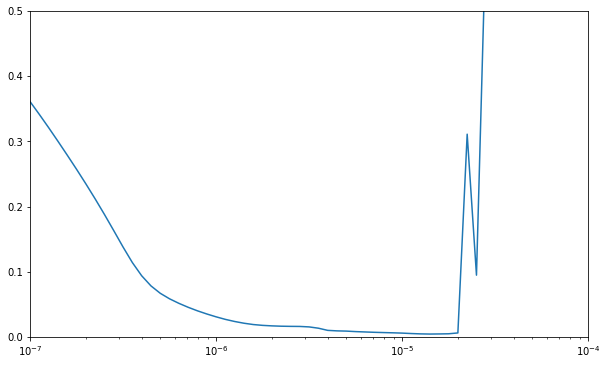

In [44]:
# ONLY RUN THIS CELL ONCE TO VIEW 'learning rate'

plt.figure(figsize=(10, 6))

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([10e-8, 10e-5, 0, 0.5])
plt.show()

In [156]:
tf.keras.backend.clear_session()

train_set = windowed_dataset(x_train_all, window_size, batch_size, shuffle_buffer_size)
val_set   = windowed_dataset(x_valid_all, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
#  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae']) # , 'acc'
history = model.fit(train_set, epochs=100, validation_data = val_set)

Epoch 1/25
211/211 [==============================] - 51s 241ms/step - loss: 0.2529 - mae: 0.6791 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/25
211/211 [==============================] - 46s 218ms/step - loss: 0.2308 - mae: 0.6486 - val_loss: 0.2112 - val_mae: 0.6263
Epoch 3/25
211/211 [==============================] - 46s 219ms/step - loss: 0.2106 - mae: 0.6192 - val_loss: 0.1923 - val_mae: 0.5976
Epoch 4/25
211/211 [==============================] - 45s 216ms/step - loss: 0.1923 - mae: 0.5912 - val_loss: 0.1752 - val_mae: 0.5702
Epoch 5/25
211/211 [==============================] - 46s 217ms/step - loss: 0.1758 - mae: 0.5645 - val_loss: 0.1596 - val_mae: 0.5441
Epoch 6/25
211/211 [==============================] - 46s 217ms/step - loss: 0.1607 - mae: 0.5389 - val_loss: 0.1454 - val_mae: 0.5189
Epoch 7/25
211/211 [==============================] - 46s 218ms/step - loss: 0.1469 - mae: 0.5143 - val_loss: 0.1324 - val_mae: 0.4947
Epoch 8/25
211/211 [===========================

In [158]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
Total params: 60,319
Trainable params: 60,319
Non-trainable params: 0
____________________________________________________

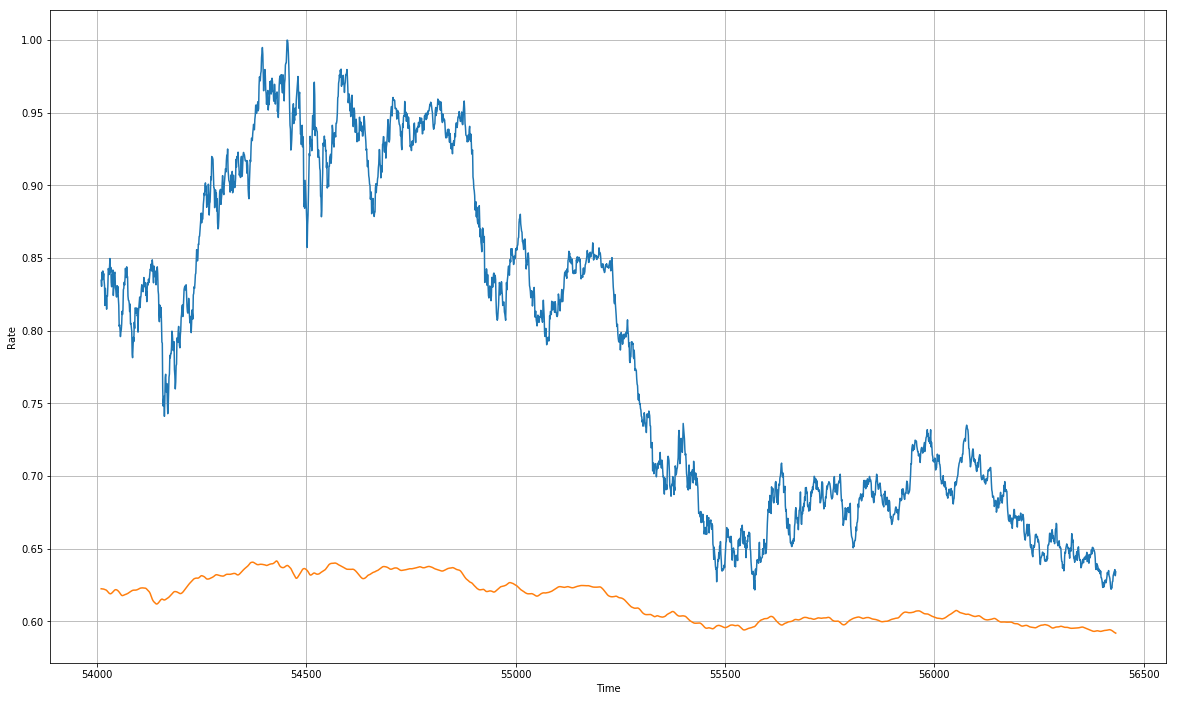

In [159]:
import matplotlib.pyplot as plt

# np. newaxis is used to increase the dimension of the existing array 
# by one dimension

rnn_forecast = model_forecast(model, x_valid_all, window_size, cnn=False)
rnn_forecast = rnn_forecast[:x_valid_len-window_size+1, -1, 0]

#rnn_forecast = rnn_forecast[x_train_len - window_size:-1, -1, 0]

plt.figure(figsize=(20, 12))
#plot_series(time_valid, x_valid)
#plot_series(time_valid, rnn_forecast)
plot_series(time_valid[:x_valid_len - window_size+1], x_valid_all[:x_valid_len - window_size+1])
plot_series(time_valid[:x_valid_len - window_size+1], rnn_forecast)

#plt.axis([10e-8, 10e-5, 0, 0.5])
plt.show()

array([-0.01406787, -0.01406959, -0.01407681, ..., -0.01155447,
       -0.01152049, -0.01148623], dtype=float32)

In [84]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

<Figure size 432x288 with 0 Axes>

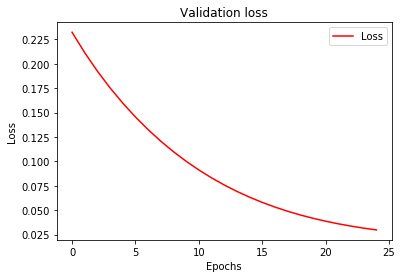

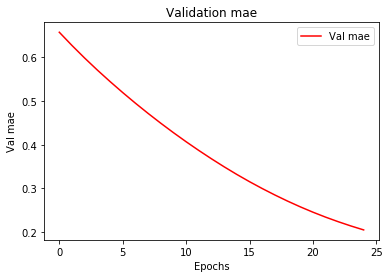

<Figure size 432x288 with 0 Axes>

In [161]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['val_loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

#------------------------------------------------
# Plot validation loss per epoch
#------------------------------------------------
mae=history.history['val_mae']

plt.plot(epochs, mae, 'r')
plt.title('Validation mae')
plt.xlabel("Epochs")
plt.ylabel("Val mae")
plt.legend(["Val mae"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
#zoomed_loss = loss[400:]
#zoomed_epochs = range(400,500)

#plt.plot(zoomed_epochs, zoomed_loss, 'r')
#plt.title('Validation loss')
#plt.xlabel("Epochs")
#plt.ylabel("Loss")
#plt.legend(["Loss"])

#plt.figure()

In [ ]:
# Write resulting dataframe to COS in parquet format
data_url = cos.url(this_stage + ".parquet", bucket_name)
df_all.write.parquet(data_url)